# Term Prediction Analysis
How does a fine-tuned model predict a term? We will examine four hypotheses here, which are:

- That a term is better predicted if it is more frequent in the training set. Remember to not use read_csv for this! Can take median of per-model prediction proportions to avoid running 32 correlations. However, we can plot and overlay the raw data to visualise (but unlikely to allow reader to distinguish between data points - maybe code by training objective).
- That a term is better predicted if its constituent tokens are more frequent within the training set. We will use the unweighted average of each term's constituent tokens. This is because each token may contribute information towards a term's predicton. A word with 3 tokens occurring at frequencies 0.5, 0, and 0 should not be considered to have its constituent tokens occur at a frequency of 0 (which would occur if we took the median).
- That a term is better predicted if it is found in the glossary (for applicable methods) - note that glossary samples differ for WCE-type methods - MWU test with 1/0 and per-model prediction rates.
- That a term is better predicted if some fraction of its constituent tokens are found within the glossary (for applicable methods) - note that glossary samples differ for WCE-type methods - Spearman's Rank Correlation with various fractions and per-model prediction rates

Assume that glossary identity is not important, but glossary membership - can do this because we just subsample the glossary all the way

In [1]:
#First, let's collect all term prediction data. We will store them in a big pandas dataframe of the form:
#TERM - MODEL - EXACT_MATCH_PROPORTION - UNCASED_MATCH_PROPORTION - LOOSE_MATCH_PROPORTION
#We will store data from opus-base separately from opus-big.
#To do this, we must first get a list of files.
from os import listdir
from os.path import isfile, join
base_path = "opus_base/"
big_path = "opus_big/"

base_files = [join(base_path, f) for f in listdir(base_path) if isfile(join(base_path, f))] #15 files, each comprising all our term predictions
big_files = [join(big_path, f) for f in listdir(big_path) if isfile(join(big_path, f))]

In [2]:
#While creating our big dataframe, we must process the dataframe from each term prediction file such that we obtain a proportion of matches per term regardless of sentence.
#That is, if we have term A being predicted perfectly in sentence 1 (e.g., 4/4), but poorly in sentence 2 (e.g., 0/4), we simply aggregate the counts to get 4/8 as our proportion.
import pandas as pd
def gen_df_from_files(list_of_files):
    df_list = []
    for filename in list_of_files: #We've checked that no terms use ", so it should be safe to predict
        curr_df = pd.read_csv(filename, sep = "\t") #First row is header
        curr_df = curr_df.drop(columns = ["sent_ID"]) #Now we only have terms and counts
        curr_df = curr_df.groupby(['fr_term'], as_index=False).sum() #Aggregate in SQL-style output
        curr_df["model_name"] = filename.replace("_terms_found.txt", "").replace("opus_base/", "").replace("opus_big/", "") #Add model origin to tag the term
        #Now, we convert our counts into proportions and remove the original count columns
        curr_df["exact_match_proportion"] = curr_df["matches_strict"] / curr_df["counts"]
        curr_df["uncased_match_proportion"] = curr_df["matches_caseless"] / curr_df["counts"]
        curr_df["loose_match_proportion"] = curr_df["matches_loose"] / curr_df["counts"]
        curr_df = curr_df.drop(columns = ["counts", "matches_strict", "matches_caseless", "matches_loose"])
        df_list.append(curr_df)
    return pd.concat(df_list)

In [3]:
base_term_preds = gen_df_from_files(base_files)
big_term_preds = gen_df_from_files(big_files)

In [4]:
#Now, we can begin examining our first hypothesis. We will take the median for each term across all models.
base_term_hyp1 = base_term_preds.drop(columns = ['model_name']).groupby(['fr_term'], as_index=False).median()
base_term_hyp1 = base_term_hyp1.rename(columns={"exact_match_proportion": "median_EMP", "uncased_match_proportion": "median_UMP", "loose_match_proportion":"median_LMP"})
big_term_hyp1 = big_term_preds.drop(columns = ['model_name']).groupby(['fr_term'], as_index=False).median()
big_term_hyp1 = big_term_hyp1.rename(columns={"exact_match_proportion": "median_EMP", "uncased_match_proportion": "median_UMP", "loose_match_proportion":"median_LMP"})

In [5]:
#Then, add word frequency data in the form of counts
input = open("train_word_frequencies.txt", "r", encoding="utf8")
words = []
counts = []
for line in input.readlines():
    line_list = line.strip().split("\t")
    words.append(line_list[0])
    counts.append(int(line_list[1]))
input.close()
train_words = pd.DataFrame(data = {"word":words, "count":counts}) #We could not use pandas' read_csv due to " being a token.

In [6]:
#Trawl our word frequency dataframe and append counts
def get_train_counts(terms):
    found_counts = []
    for term in terms:
        count_df = train_words[train_words["word"] == term] #Only one exact match at most
        if (count_df.empty):
            count = 0
        else:
            count = count_df["count"].values[0]
        found_counts.append(count)
    return found_counts

In [7]:
import numpy as np
base_term_hyp1["train_counts"] = get_train_counts(base_term_hyp1["fr_term"])
big_term_hyp1["train_counts"] = get_train_counts(big_term_hyp1["fr_term"])

In [8]:
base_term_hyp1["log_train_counts"] = np.log(base_term_hyp1["train_counts"] + 1)
big_term_hyp1["log_train_counts"] = np.log(big_term_hyp1["train_counts"] + 1)

<Axes: title={'center': 'Plot of training set count against median uncased match proportion per term (opus-big)'}, xlabel='Median uncased match proportion', ylabel='Log (count + 1)'>

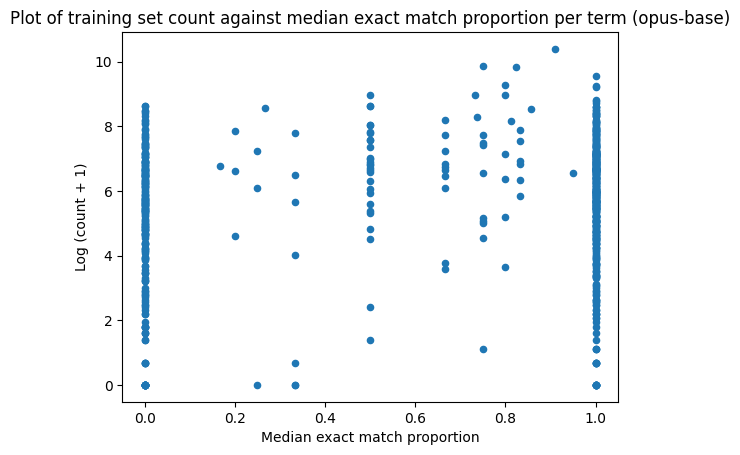

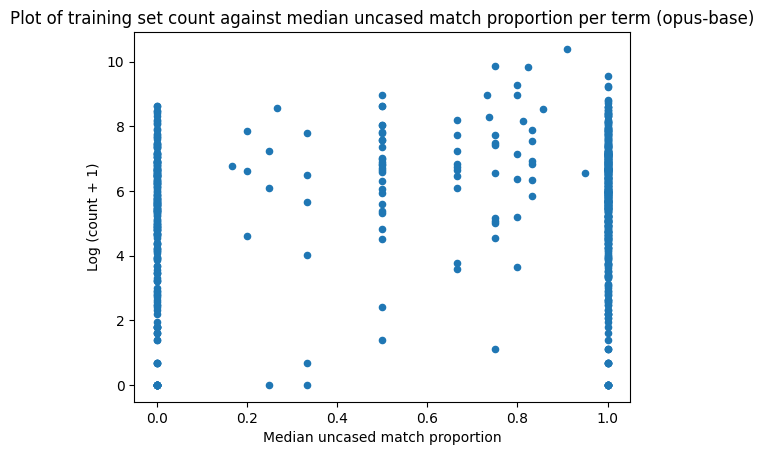

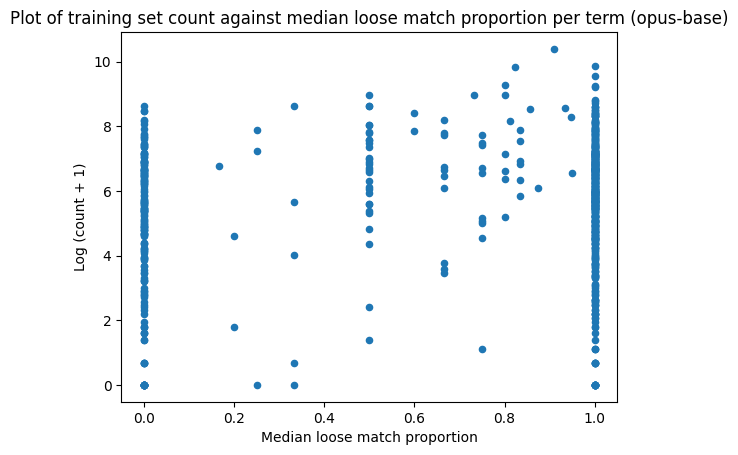

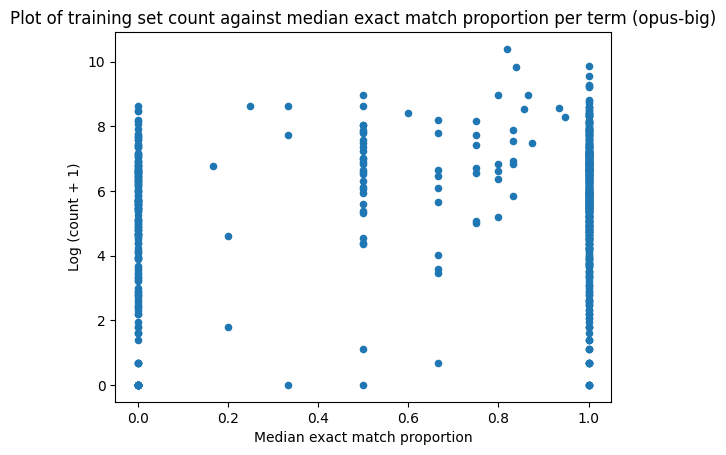

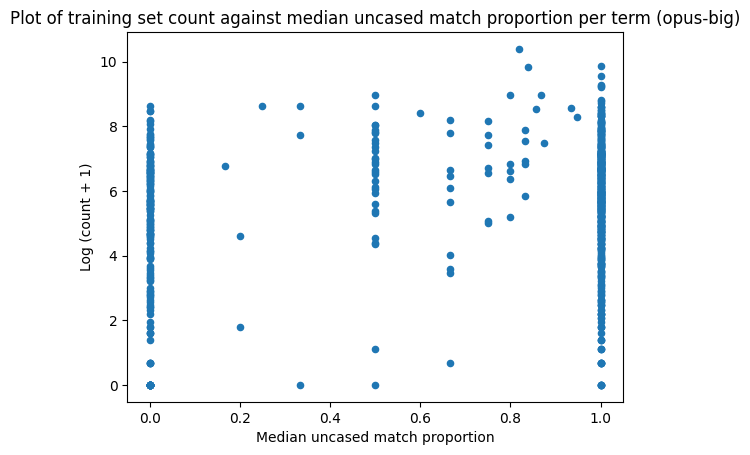

In [9]:
#There doesn't seem to be a correlation, to be honest.
base_term_hyp1.plot(x = "median_EMP", y = "log_train_counts", xlabel = "Median exact match proportion", ylabel = "Log (count + 1)", 
                    title = "Plot of training set count against median exact match proportion per term (opus-base)", kind = "scatter")
base_term_hyp1.plot(x = "median_UMP", y = "log_train_counts", xlabel = "Median uncased match proportion", ylabel = "Log (count + 1)", 
                    title = "Plot of training set count against median uncased match proportion per term (opus-base)", kind = "scatter")
base_term_hyp1.plot(x = "median_LMP", y = "log_train_counts", xlabel = "Median loose match proportion", ylabel = "Log (count + 1)", 
                    title = "Plot of training set count against median loose match proportion per term (opus-base)", kind = "scatter")
big_term_hyp1.plot(x = "median_EMP", y = "log_train_counts", xlabel = "Median exact match proportion", ylabel = "Log (count + 1)", 
                    title = "Plot of training set count against median exact match proportion per term (opus-big)", kind = "scatter")
big_term_hyp1.plot(x = "median_UMP", y = "log_train_counts", xlabel = "Median uncased match proportion", ylabel = "Log (count + 1)", 
                    title = "Plot of training set count against median uncased match proportion per term (opus-big)", kind = "scatter")

In [10]:
from scipy import stats #Apparently, we find a very weak positive correlation for all statistics.  
#[NB: If it were not sig diff from 0, the p-value would state so and we would declare no correlation] 
res = stats.spearmanr(base_term_hyp1["train_counts"],base_term_hyp1["median_EMP"], alternative='greater')
print(res.statistic)
print(res.pvalue)
res = stats.spearmanr(base_term_hyp1["train_counts"],base_term_hyp1["median_UMP"], alternative='greater')
print(res.statistic)
print(res.pvalue)
res = stats.spearmanr(base_term_hyp1["train_counts"],base_term_hyp1["median_LMP"], alternative='greater')
print(res.statistic)
print(res.pvalue)
res = stats.spearmanr(big_term_hyp1["train_counts"],big_term_hyp1["median_EMP"], alternative='greater')
print(res.statistic)
print(res.pvalue)
res = stats.spearmanr(big_term_hyp1["train_counts"],big_term_hyp1["median_UMP"], alternative='greater')
print(res.statistic)
print(res.pvalue)

0.11101693062355604
0.0019658352084819157
0.10200873783718979
0.004044556034023245
0.10111963813434255
0.004330854018072233
0.12584738862250835
0.0005344948064473153
0.12100590451070593
0.0008307398642722986


Having investigated hypothesis 1, we find a significant but very weak positive correlation between the proportion of correct term predictions and the frequency (expressed as counts) of the predicted term in the training set. This correlation applies to all models and variants of TUR, but appears to be slightly stronger for opus-big than opus-base, perhaps due to memorisation. It is also slightly stronger for more exact matches - perhaps because words which are not as frequent in the training set tend to have more errors (but are still deemed to be correct)

In [11]:
#Now, we examine hypothesis 2.
base_term_hyp2 = base_term_hyp1.drop(columns = ["train_counts", "log_train_counts"])
big_term_hyp2 = big_term_hyp1.drop(columns = ["train_counts", "log_train_counts"])                                

In [12]:
train_base_tokens = pd.read_csv("train_token_base_freq.txt", sep = "\t", header = None, names = ["token_ID", "frequency"])
train_big_tokens = pd.read_csv("train_token_big_freq.txt", sep = "\t", header = None, names = ["token_ID", "frequency"])

In [13]:
#Generate estimates of per-term token frequency
def fill_term_token_frequency(term_list, token_freq_df, tokeniser, special_tokens):
    all_term_tok_freq = []
    for term in term_list:
        list_of_tokens = tokeniser(text_target = term)["input_ids"]
        term_tok_freq = []
        for token_id in list_of_tokens:
            if (token_id in special_tokens):
                continue
            found = token_freq_df[token_freq_df["token_ID"] == token_id] #Each ID is unique
            if (found.empty):
                tok_freq = 0
            else:
                tok_freq = found["frequency"].values[0]
            term_tok_freq.append(tok_freq)
        #At this point we have constituent token frequencies for some term excluding special tokens. We then find the average.
        if (len(term_tok_freq) == 0): #Account for terms fully composed of special tokens
            avg = 0
        else:
            avg = sum(term_tok_freq) / len(term_tok_freq)
        all_term_tok_freq.append(avg)
    return all_term_tok_freq

In [14]:
from transformers import AutoTokenizer
opus_base_checkpoint = "Helsinki-NLP/opus-mt-en-fr"
opus_big_checkpoint = "Helsinki-NLP/opus-mt-tc-big-en-fr"
opus_base_tokenizer = AutoTokenizer.from_pretrained(opus_base_checkpoint)
opus_big_tokenizer = AutoTokenizer.from_pretrained(opus_big_checkpoint)
BASE_SPECIAL_TOKENS = [0, 1, 59513]
BIG_SPECIAL_TOKENS = [43311, 50387, 43312, 53016]

In [15]:
base_term_hyp2["constituent_token_frequency"] = fill_term_token_frequency(base_term_hyp2["fr_term"], train_base_tokens, opus_base_tokenizer, BASE_SPECIAL_TOKENS)
big_term_hyp2["constituent_token_frequency"] = fill_term_token_frequency(big_term_hyp2["fr_term"], train_big_tokens, opus_big_tokenizer, BIG_SPECIAL_TOKENS)

<Axes: title={'center': 'Plot of training set token frequency against median uncased match proportion per term (opus-big)'}, xlabel='Median uncased match proportion', ylabel='Log (token frequency + 1)'>

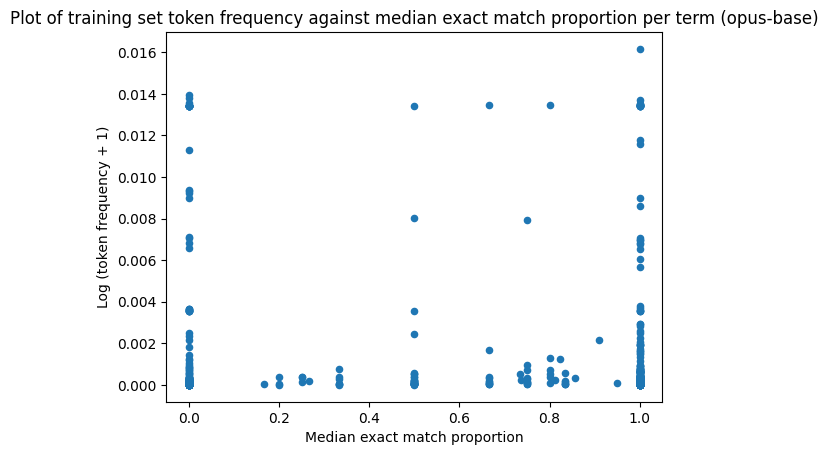

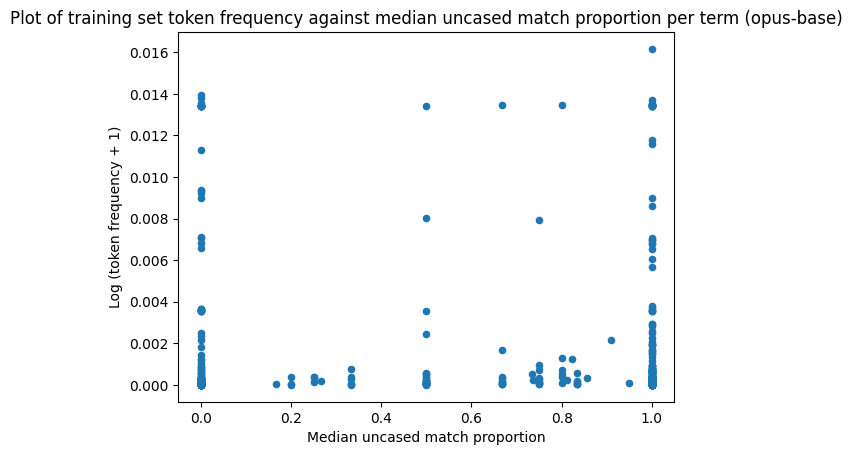

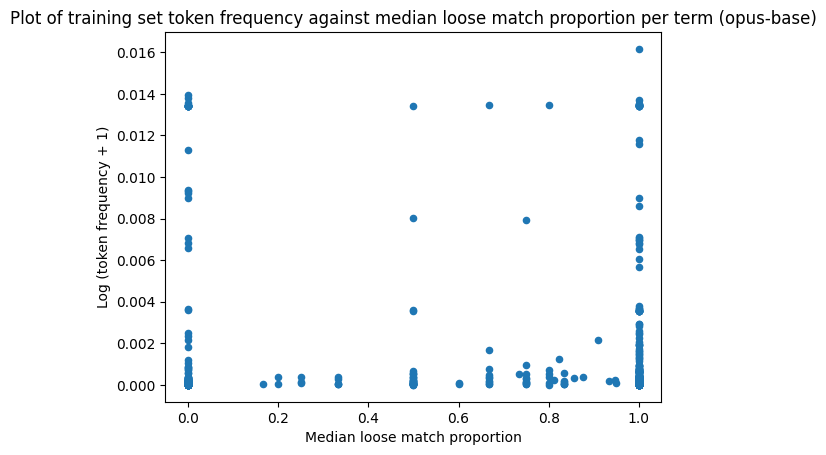

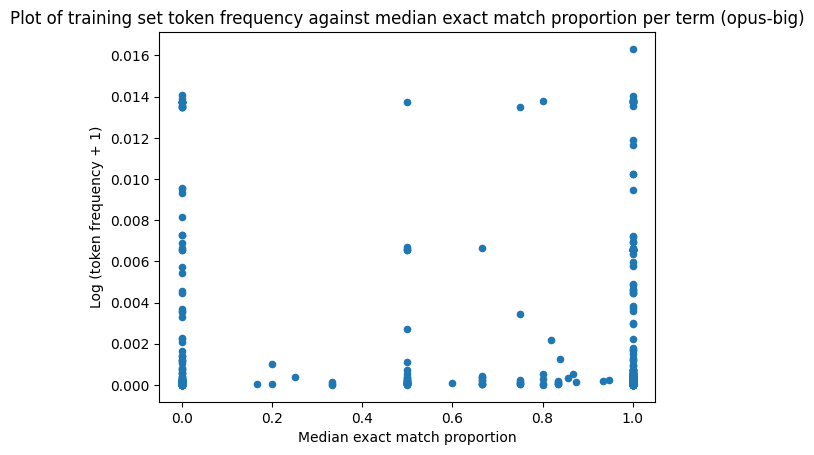

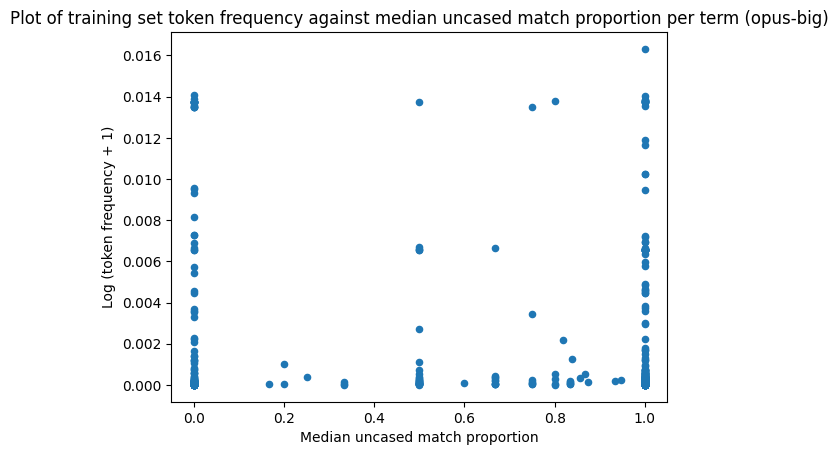

In [16]:
#Do our usual log-dependent variable plotting
base_term_hyp2["log_ctf"] = np.log(base_term_hyp2["constituent_token_frequency"] + 1)
big_term_hyp2["log_ctf"] = np.log(big_term_hyp2["constituent_token_frequency"] + 1)
#There doesn't seem to be a correlation again, huh.
base_term_hyp2.plot(x = "median_EMP", y = "log_ctf", xlabel = "Median exact match proportion", ylabel = "Log (token frequency + 1)", 
                    title = "Plot of training set token frequency against median exact match proportion per term (opus-base)", kind = "scatter")
base_term_hyp2.plot(x = "median_UMP", y = "log_ctf", xlabel = "Median uncased match proportion", ylabel = "Log (token frequency + 1)", 
                    title = "Plot of training set token frequency against median uncased match proportion per term (opus-base)", kind = "scatter")
base_term_hyp2.plot(x = "median_LMP", y = "log_ctf", xlabel = "Median loose match proportion", ylabel = "Log (token frequency + 1)", 
                    title = "Plot of training set token frequency against median loose match proportion per term (opus-base)", kind = "scatter")
big_term_hyp2.plot(x = "median_EMP", y = "log_ctf", xlabel = "Median exact match proportion", ylabel = "Log (token frequency + 1)", 
                    title = "Plot of training set token frequency against median exact match proportion per term (opus-big)", kind = "scatter")
big_term_hyp2.plot(x = "median_UMP", y = "log_ctf", xlabel = "Median uncased match proportion", ylabel = "Log (token frequency + 1)", 
                    title = "Plot of training set token frequency against median uncased match proportion per term (opus-big)", kind = "scatter")

In [17]:
#No significant correlation found for all indices. 
#That's interesting - I would have thought that the more we see constituent tokens, the more likely the model emits those tokens correctly, even if they are part of a term. Perhaps this
#is due to our insistence on exact matches - we essentially require all tokens to be present for a term to enter our data.
#This means that correct term prediction uses word-level patterns, rather than token-level patterns. This is an argument in support of default WCE, or at the very least, against thinking
#about learning signal precision at the token level. Maybe we can leave this one for future research...
res = stats.spearmanr(base_term_hyp2["constituent_token_frequency"],base_term_hyp2["median_EMP"], alternative='greater')
print(res.statistic)
print(res.pvalue)
res = stats.spearmanr(base_term_hyp2["constituent_token_frequency"],base_term_hyp2["median_UMP"], alternative='greater')
print(res.statistic)
print(res.pvalue)
res = stats.spearmanr(base_term_hyp2["constituent_token_frequency"],base_term_hyp2["median_LMP"], alternative='greater')
print(res.statistic)
print(res.pvalue)
res = stats.spearmanr(big_term_hyp2["constituent_token_frequency"],big_term_hyp2["median_EMP"], alternative='greater')
print(res.statistic)
print(res.pvalue)
res = stats.spearmanr(big_term_hyp2["constituent_token_frequency"],big_term_hyp2["median_UMP"], alternative='greater')
print(res.statistic)
print(res.pvalue)

-0.0077367300365843005
0.5793918883039932
-0.0211549756486743
0.708102080868704
-0.009693689433332087
0.5990985390008055
-0.06365339917171212
0.9505199142458679
-0.07605533296915787
0.9757086313358707


In [18]:
#Now, let's examine hypothesis 3. We need to load in our glossaries first.
from datasets import load_dataset, Dataset
#Converts data in src [TAB] tgt [NEWLINE] format to a format suitable for model training
def convertToDictFormat(data):
    source = []
    target = []
    for example in data:
        example = example.strip()
        sentences = example.split("\t")
        source.append(sentences[0])
        target.append(sentences[1])
    ready = Dataset.from_dict({"en":source, "fr":target})
    return ready
entire_glossary = load_dataset("ethansimrm/MeSpEn_enfr_cleaned_glossary", split = "train")
entire_glossary_fr = convertToDictFormat(entire_glossary['text'])['fr']
intersect_glossary = load_dataset("ethansimrm/sampled_glossary_1.0_train", split = "train")
intersect_glossary_fr = convertToDictFormat(intersect_glossary['text'])['fr']
lsp_glossary_fr = load_dataset("ethansimrm/lsp_terms", split = "train")['text'] #This one only has the FR terms

Found cached dataset text (C:/Users/ethan/.cache/huggingface/datasets/ethansimrm___text/ethansimrm--MeSpEn_enfr_cleaned_glossary-e1fb9a6b67efd03c/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)
Found cached dataset text (C:/Users/ethan/.cache/huggingface/datasets/ethansimrm___text/ethansimrm--sampled_glossary_1.0_train-2f618074f2b08fee/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)
Found cached dataset text (C:/Users/ethan/.cache/huggingface/datasets/ethansimrm___text/ethansimrm--lsp_terms-b5176c513ba2c499/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)


In [31]:
#For our third hypothesis, we only have two levels - found in glossary and not found in glossary. This demands a Mann-Whitney U test, which checks if the medians of these two unbalanced 
#groups are significantly different. We will operate directly on the original dataframe to do this.
#Our naming scheme was as such: if it has lsp --> LSP glossary. if it has unsampled --> entire glossary. if it has adapt_wce but NOT unsampled --> intersect. 
#Everything else --> entire glossary.
#We need to ignore our unmodified fine-tuned models - these didn't use the glossary at all.

def find_in_glossary(terms_and_model_names):
    found_in_gloss = []
    for row in terms_and_model_names.itertuples():
        if ("lsp" in row.model_name):
            found_in_gloss.append(row.fr_term in lsp_glossary_fr)
        elif (("adapt" in row.model_name) and ("unsampled" not in row.model_name)):
            found_in_gloss.append(row.fr_term in intersect_glossary_fr)
        else:
            found_in_gloss.append(row.fr_term in entire_glossary_fr)
    return found_in_gloss

base_term_preds["found_in_glossary"] = find_in_glossary(base_term_preds[["fr_term", "model_name"]])
base_term_hyp3 = base_term_preds.rename(columns={"exact_match_proportion": "Exact", 
                                                 "uncased_match_proportion": "Uncased", "loose_match_proportion":"Loose"})[base_term_preds["model_name"] != "opus_wmt_finetuned_enfr_hpc"] 
big_term_preds["found_in_glossary"] = find_in_glossary(big_term_preds[["fr_term", "model_name"]])
big_term_hyp3 = big_term_preds.rename(columns={"exact_match_proportion": "Exact", 
                                               "uncased_match_proportion": "Uncased", "loose_match_proportion":"Loose"})[big_term_preds["model_name"] != "opus_big_enfr_FT"]

Text(0.5, 0.98, 'Matches grouped by term presence in glossary (opus-big)')

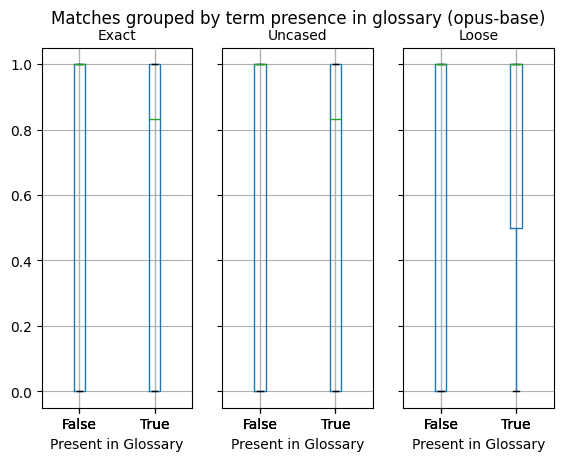

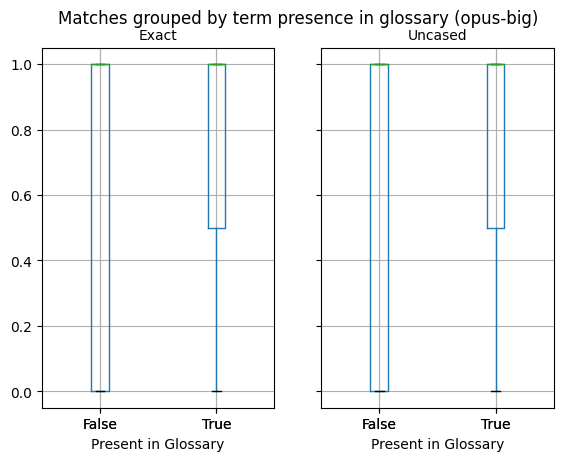

In [32]:
#I'm honestly not sure what I'm seeing here. Presence in the glossary seems to improve term prediction by cutting off the bottom part of the boxplot - we get fewer poor matches.
#However, the median - the measure of central tendency - looks very similar when this happens. I'm predicting no correlation again...
base_boxplot = base_term_hyp3.boxplot(by = "found_in_glossary", column = ["Exact", "Uncased", "Loose"], xlabel = "Present in Glossary", layout = (1, 3))
for fig in base_boxplot:
    fig.set_title(label = fig.get_title(), fontsize = 10)
base_boxplot[0].get_figure().suptitle("Matches grouped by term presence in glossary (opus-base)")

big_boxplot = big_term_hyp3.boxplot(by = "found_in_glossary", column = ["Exact", "Uncased"], xlabel = "Present in Glossary", layout = (1, 2))
for fig in big_boxplot:
    fig.set_title(label = fig.get_title(), fontsize = 10)
big_boxplot[0].get_figure().suptitle("Matches grouped by term presence in glossary (opus-big)")

In [33]:
#We assume that for all matches involving term A, the case where term A occurs in the glossary is independent of the case where term A does not occur in the glossary - 
#that is, we don't assume that some terms are inherently easier or harder to predict.
#We find no significant difference in median match proportion using MWU. Whether a term is predicted well doesn't depend on whether a term is within the (method-specific) glossary,
#even though most of the methods use glossaries! I suppose the training set has a much greater effect on model performance than the glossary no matter what (which makes sense).
base_found = base_term_hyp3[base_term_hyp3["found_in_glossary"] == True]
base_not_found = base_term_hyp3[base_term_hyp3["found_in_glossary"] == False]
big_found = big_term_hyp3[big_term_hyp3["found_in_glossary"] == True]
big_not_found = big_term_hyp3[big_term_hyp3["found_in_glossary"] == False]

res = stats.mannwhitneyu(base_found["Exact"], base_not_found["Exact"], alternative = "greater")
print(res.statistic)
print(res.pvalue)
res = stats.mannwhitneyu(base_found["Uncased"], base_not_found["Uncased"], alternative = "greater")
print(res.statistic)
print(res.pvalue)
res = stats.mannwhitneyu(base_found["Loose"], base_not_found["Loose"], alternative = "greater")
print(res.statistic)
print(res.pvalue)
res = stats.mannwhitneyu(big_found["Exact"], big_not_found["Exact"], alternative = "greater")
print(res.statistic)
print(res.pvalue)
res = stats.mannwhitneyu(big_found["Uncased"], big_not_found["Uncased"], alternative = "greater")
print(res.statistic)
print(res.pvalue)

4415628.5
0.9999999979241319
4384751.0
0.9999999998474206
4868467.5
0.5073103991490711
4965873.5
0.09940608112573018
4932524.0
0.19992543751365094


In [34]:
#Finally, let's examine hypothesis 4. 
base_term_hyp4 = base_term_hyp3.drop(columns = ["found_in_glossary"])
big_term_hyp4 = big_term_hyp3.drop(columns = ["found_in_glossary"])

In [35]:
#We must first tokenise and run a counter over each of our glossaries.
from collections import Counter
def get_unique_tokens(fr_glossary, tokenizer, special_tokens):
    tokenized_gloss = tokenizer(text_target = fr_glossary)["input_ids"]
    gloss_tokens = []
    for token_group in tokenized_gloss:
        gloss_tokens += token_group
    counted_tokens = Counter(gloss_tokens)
    for unwanted_tok in special_tokens:
        del counted_tokens[unwanted_tok]
    return list(counted_tokens.keys())

In [36]:
tokenised_entire_gloss_base = get_unique_tokens(entire_glossary_fr, opus_base_tokenizer, BASE_SPECIAL_TOKENS)
tokenised_entire_gloss_big = get_unique_tokens(entire_glossary_fr, opus_big_tokenizer, BIG_SPECIAL_TOKENS)
tokenised_intersect_gloss_base = get_unique_tokens(intersect_glossary_fr, opus_base_tokenizer, BASE_SPECIAL_TOKENS)
tokenised_intersect_gloss_big = get_unique_tokens(intersect_glossary_fr, opus_big_tokenizer, BIG_SPECIAL_TOKENS)
tokenised_lsp_gloss_base = get_unique_tokens(lsp_glossary_fr, opus_base_tokenizer, BASE_SPECIAL_TOKENS)
tokenised_lsp_gloss_big = get_unique_tokens(lsp_glossary_fr, opus_big_tokenizer, BIG_SPECIAL_TOKENS)

In [37]:
#Next, we will tokenise all words and obtain the proportion of tokens found in the glossary
def fill_term_found_gloss_token_proportion(terms_and_model_names, tokeniser, special_tokens, model_type):
    if (model_type == "opus-base"):
        fr_tok_lsp_gloss = tokenised_lsp_gloss_base
        fr_tok_intersect_gloss = tokenised_intersect_gloss_base
        fr_tok_entire_gloss = tokenised_entire_gloss_base
    elif (model_type == "opus-big"):
        fr_tok_lsp_gloss = tokenised_lsp_gloss_big
        fr_tok_intersect_gloss = tokenised_intersect_gloss_big
        fr_tok_entire_gloss = tokenised_entire_gloss_big
    else:
        return
    all_term_tok_found_proportion = []
    for row in terms_and_model_names.itertuples():
        list_of_tokens = tokeniser(text_target = row.fr_term)["input_ids"]
        term_tok_found_proportion = []
        for token_id in list_of_tokens:
            if (token_id in special_tokens):
                continue
            if ("lsp" in row.model_name):
                term_tok_found_proportion.append(int(token_id in fr_tok_lsp_gloss))
            elif (("adapt" in row.model_name) and ("unsampled" not in row.model_name)):
                term_tok_found_proportion.append(int(token_id in fr_tok_intersect_gloss))
            else:
                term_tok_found_proportion.append(int(token_id in fr_tok_entire_gloss))
        #At this point we have present = 1, absent = 0 for all tokens comprising some term excluding special tokens. We then find the average (i.e. proportion found).
        if (len(term_tok_found_proportion) == 0): #Account for terms fully composed of special tokens
            found_prop = 0
        else: 
            found_prop = sum(term_tok_found_proportion) / len(term_tok_found_proportion)
        all_term_tok_found_proportion.append(found_prop)
    return all_term_tok_found_proportion

In [38]:
base_term_hyp4["term_tok_glossary_found_proportion"] = fill_term_found_gloss_token_proportion(
    base_term_hyp4[["fr_term", "model_name"]], opus_base_tokenizer, BASE_SPECIAL_TOKENS, "opus-base")
big_term_hyp4["term_tok_glossary_found_proportion"] = fill_term_found_gloss_token_proportion(
    big_term_hyp4[["fr_term", "model_name"]], opus_big_tokenizer, BIG_SPECIAL_TOKENS, "opus-big")

<Axes: title={'center': 'Plot of proportion of tokens found in glossary against uncased match proportion per term (opus-big)'}, xlabel='Uncased match proportion', ylabel='Proportion of tokens found in glossary'>

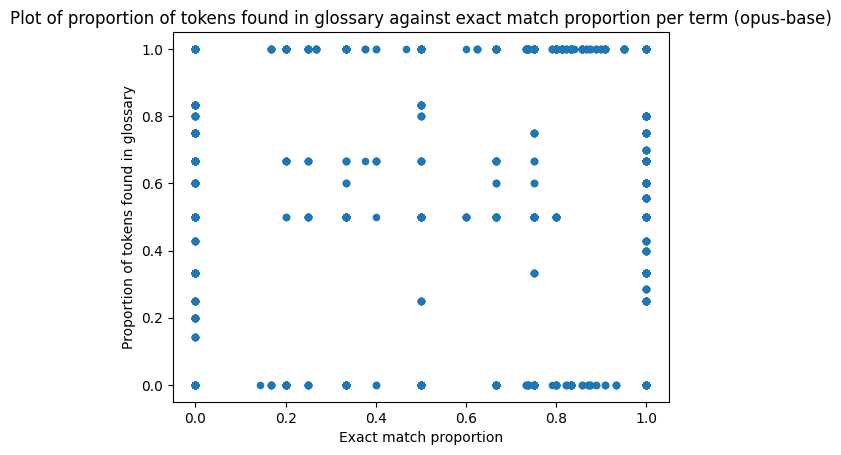

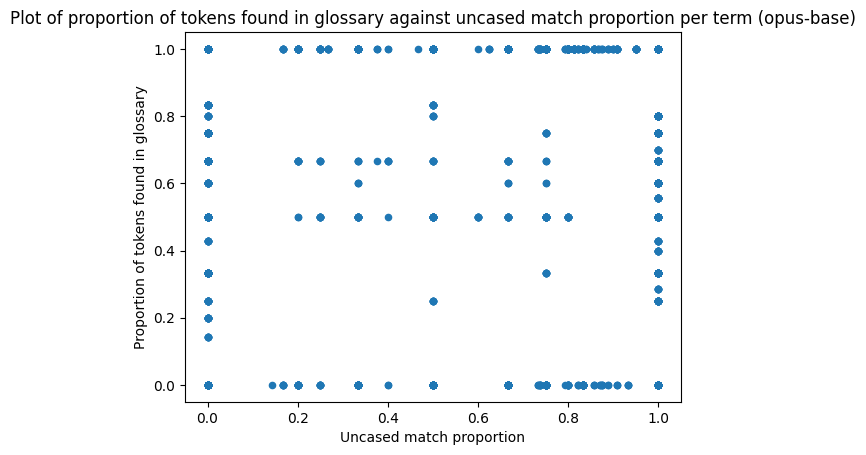

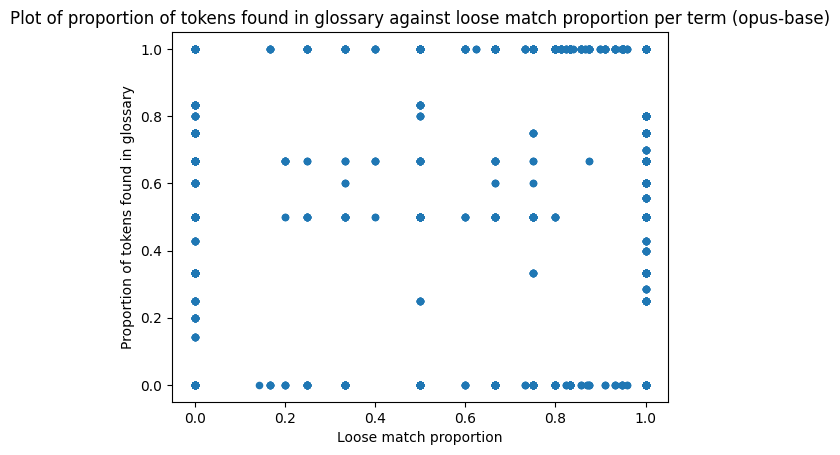

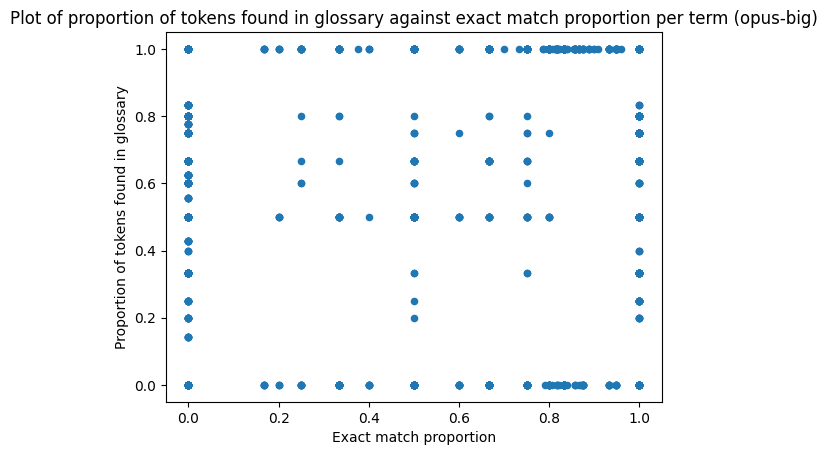

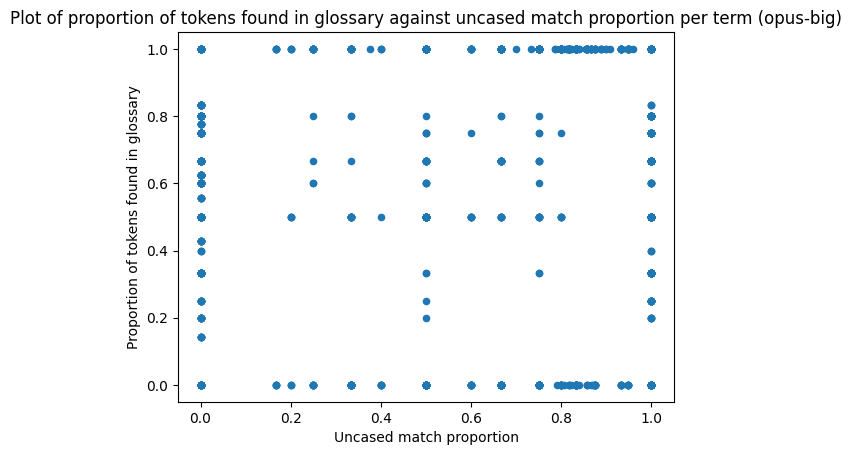

In [39]:
#I don't see any correlation again. This is quite disappointing...
base_term_hyp4.plot(x = "Exact", y = "term_tok_glossary_found_proportion", xlabel = "Exact match proportion", ylabel = "Proportion of tokens found in glossary", 
                    title = "Plot of proportion of tokens found in glossary against exact match proportion per term (opus-base)", kind = "scatter")
base_term_hyp4.plot(x = "Uncased", y = "term_tok_glossary_found_proportion", xlabel = "Uncased match proportion", ylabel = "Proportion of tokens found in glossary", 
                    title = "Plot of proportion of tokens found in glossary against uncased match proportion per term (opus-base)", kind = "scatter")
base_term_hyp4.plot(x = "Loose", y = "term_tok_glossary_found_proportion", xlabel = "Loose match proportion", ylabel = "Proportion of tokens found in glossary", 
                    title = "Plot of proportion of tokens found in glossary against loose match proportion per term (opus-base)", kind = "scatter")
big_term_hyp4.plot(x = "Exact", y = "term_tok_glossary_found_proportion", xlabel = "Exact match proportion", ylabel = "Proportion of tokens found in glossary", 
                    title = "Plot of proportion of tokens found in glossary against exact match proportion per term (opus-big)", kind = "scatter")
big_term_hyp4.plot(x = "Uncased", y = "term_tok_glossary_found_proportion", xlabel = "Uncased match proportion", ylabel = "Proportion of tokens found in glossary", 
                    title = "Plot of proportion of tokens found in glossary against uncased match proportion per term (opus-big)", kind = "scatter")

In [40]:
#Very confusing. Don't split hairs on the Spearman value - just report sig or non-sig. 
res = stats.spearmanr(base_term_hyp4["term_tok_glossary_found_proportion"], base_term_hyp4["Exact"], alternative='greater')
print(res.statistic)
print(res.pvalue)
res = stats.spearmanr(base_term_hyp4["term_tok_glossary_found_proportion"], base_term_hyp4["Uncased"], alternative='greater')
print(res.statistic)
print(res.pvalue)
res = stats.spearmanr(base_term_hyp4["term_tok_glossary_found_proportion"], base_term_hyp4["Loose"], alternative='greater') #Very very weak positive correlation
print(res.statistic)
print(res.pvalue)
res = stats.spearmanr(big_term_hyp4["term_tok_glossary_found_proportion"], big_term_hyp4["Exact"], alternative='greater') #Very very weak positive correlation
print(res.statistic)
print(res.pvalue)
res = stats.spearmanr(big_term_hyp4["term_tok_glossary_found_proportion"], big_term_hyp4["Uncased"], alternative='greater') #Very very weak positive correlation
print(res.statistic)
print(res.pvalue)

5.958316788006518e-05
0.49769301292689927
-0.007600383963529196
0.769639197522827
0.028640071913505562
0.0027162136265689377
0.026986339449691598
0.00440149085589918
0.02130109841704814
0.019339122972556206
